This notebook will present the results of the experiments. The goal of the experiments is to find an optimal preprocessing technique and distance metric. 

Firstly, we will import everything that we need and load the data.

In [ ]:
import nltk
import pandas as pd
import numpy as np
import spacy
#nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from data.test_data import original, easy, medium, hard
from sklearn.neighbors import NearestNeighbors
from nltk.stem import SnowballStemmer


corpus_train = pd.read_csv('../../data/insurance_qna_dataset.csv', sep='\t')
corpus = corpus_train.drop(corpus_train.columns[0], axis = 1)
corpus_full = list(corpus_train["Question"])+list(corpus_train["Answer"])
corpus_train = list(corpus_train["Question"])
changed = easy + medium + hard
corpus_test = pd.DataFrame({'Original': 3 * original, 'Changed': changed})

After loading the data, the preprocessing is done.

In [ ]:
class Lemmatization:
    def __init__(self):
        self.lem = spacy.load('en_core_web_sm')

    def lemmatize_text(self, text):
        doc = self.lem(text)
        lemmatized_text = ' '.join([token.lemma_ for token in doc])
        return lemmatized_text

    def lemmatize_dataframe(self, df, column):
        df_lemmatized = df.copy()
        df_lemmatized[column] = df_lemmatized[column].apply(self.lemmatize_text)
        return df_lemmatized

class Stemming():
    def __init__(self):
        self.stemmer = SnowballStemmer(language='english')

    def stem_text(self, text):
        doc = nltk.word_tokenize(text)
        stemmed_text = ' '.join([self.stemmer.stem(token) for token in doc])
        return  stemmed_text

    def stem_dataframe(self, df, column):
        df_stemmed = df.copy()
        df_stemmed[column] = df_stemmed[column].apply(self.stem_text)
        return df_stemmed


stemmer = Stemming()
corpus_stemmed = stemmer.stem_dataframe(corpus, 'Question')
corpus_stemmed_full = list(corpus_stemmed["Question"])+list(corpus_stemmed["Answer"])
corpus_stemmed_questions = list(corpus_stemmed["Question"])


lemmatizer = Lemmatization()
corpus_lemmatized = lemmatizer.lemmatize_dataframe(corpus, 'Question')
corpus_lemmatized_full = list(corpus_lemmatized["Question"])+list(corpus_lemmatized["Answer"])
corpus_lemmatized_questions = list(corpus_lemmatized["Question"])

After preprocessing the data, it is necessary to vectorize the data using TF-IDF (term frequency - inverse document frequency). TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

Also, in the TfIdfVectorizerClass class in constructor is specified which n-grams we want to be extracted. I tried to extract unigrams and bigrams and only unigrams too.

In [ ]:
class TfIdfVectorizerClass:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(ngram_range=(1,2))

    def fit(self, corpus):
        return self.vectorizer.fit(corpus)

    def transform(self, corpus):
        return self.vectorizer.transform(corpus)


tfidf_vectorizer = TfIdfVectorizerClass()
tfidf_vectorizer.fit(corpus_full)
tfidf_matrix = tfidf_vectorizer.transform(corpus_train)
vectorized = tfidf_vectorizer.transform(corpus_test["Changed"])

At the end, it is necessary to evaluate the model and metric. It is done by checking if the original question is within 100 nearest neighbors and determining its rank. After that we calulate the mean rank, and the metric with lowest rank is the best one. 

In [ ]:
nbrs_euclidean = NearestNeighbors(n_neighbors=100, metric='euclidean').fit(tfidf_matrix)
nbrs_manhattan = NearestNeighbors(n_neighbors=100, metric='manhattan').fit(tfidf_matrix)
nbrs_cosine = NearestNeighbors(n_neighbors=100, metric='cosine').fit(tfidf_matrix)

def calculate_rank(metric, matrix, corpus_train):
    if metric == 'euclidean':
        distances, indices = nbrs_euclidean.kneighbors(matrix)
    elif metric == 'manhattan':
        distances, indices = nbrs_manhattan.kneighbors(matrix)
    else:
        distances, indices = nbrs_cosine.kneighbors(matrix)


    ranks = []
    for index_list in indices:
        for i, index in enumerate(index_list):
            #print(corpus_train.index(corpus_train[index]), index)
            if corpus_train.index(corpus_train[index]) == index:
                ranks.append(i)
            else:
                ranks.append(200)
    return ranks


def calculate_mean_rank(matrix, corpus_train):
    euclidean_rank = calculate_rank('euclidean', matrix, corpus_train)
    manhattan_rank = calculate_rank('manhattan', matrix, corpus_train)
    cosine_rank = calculate_rank('cosine', matrix, corpus_train)

    mean_euclidean_rank = np.mean(euclidean_rank)
    mean_manhattan_rank = np.mean(manhattan_rank)
    mean_cosine_rank = np.mean(cosine_rank)

    return mean_euclidean_rank, mean_manhattan_rank, mean_cosine_rank


def find_best_metric(matrix, corpus_train):
    mean_euclidean_rank, mean_manhattan_rank, mean_cosine_rank = calculate_mean_rank(matrix, corpus_train)
    best_rank = min(mean_euclidean_rank, mean_manhattan_rank, mean_cosine_rank)

    if best_rank == mean_euclidean_rank:
        best_metric = 'euclidean'
    elif best_rank == mean_manhattan_rank:
        best_metric = 'manhattan'
    else:
        best_metric = 'cosine'

    return print("The best metric is", best_metric, ".Rank is: ", best_rank)
    

print("Mean ranks - euclidean, manhattan & cosine", calculate_mean_rank(vectorized, corpus_train))
print(find_best_metric(vectorized, corpus_train))



In [ ]:
The results of the experiments are given in the table below. The conclusion is that in the TF-IDF case, it is best to use stemming and manhattan distance, and unigrams + bigrams. 
(note: only unigrams were tested, but the results were worse)

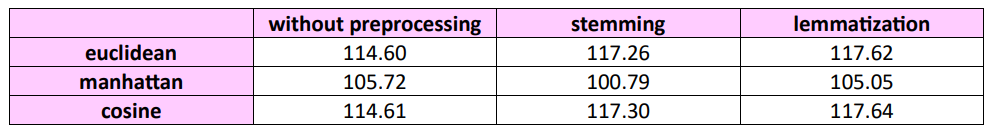